In [4]:
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

In [2]:
def preprocess_flags(flags_dir):
    flag_features = []
    
    for flag_file in os.listdir(flags_dir):
        img = cv2.imread(os.path.join(flags_dir, flag_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 70))  # Standardize size
        
        # Extract color histogram
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = hist.flatten()
        
        # Normalize histogram
        hist = hist / np.sum(hist)
        
        flag_features.append(hist)

    scaler = StandardScaler()
    flag_features = scaler.fit_transform(flag_features)
    
    return flag_features

In [5]:
flag_features = preprocess_flags(r"C:\Users\ASUS\MMDP\png100px")

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
def preprocess_anthems(anthems_dir):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    anthem_texts = []
    
    for anthem_file in os.listdir(anthems_dir):
        with open(os.path.join(anthems_dir, anthem_file), 'r', encoding='utf-8') as f:
            text = f.read().lower()
        
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        # Join tokens back into a string
        text = ' '.join(tokens)
        
        anthem_texts.append(text)

    # Use TF-IDF for feature extraction
    vectorizer = TfidfVectorizer(max_features=5000)
    anthem_features = vectorizer.fit_transform(anthem_texts)
    
    return anthem_features.toarray()

In [8]:
anthem_features = preprocess_anthems(r"C:\Users\ASUS\MMDP\anthem_texts")

In [9]:
import librosa

In [10]:
def preprocess_audio(audio_dir):
    audio_features = []
    
    for audio_file in os.listdir(audio_dir):
        y, sr = librosa.load(os.path.join(audio_dir, audio_file))
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        mfccs = mfccs.mean(axis=1)  # Average across frames
        
        # Extract spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

        features = np.concatenate([mfccs, [spectral_centroid, spectral_bandwidth, spectral_rolloff]])
        audio_features.append(features)
    
    # Scale features using StandardScaler
    scaler = StandardScaler()
    audio_features = scaler.fit_transform(audio_features)
    
    return audio_features

In [11]:
audio_features = preprocess_audio(r"C:\Users\ASUS\MMDP\anthems_audio")

In [12]:
def reduce_dimensions(features, n_components):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

In [14]:
from sklearn.cross_decomposition import CCA
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt

In [16]:
cca = CCA(n_components=5)
min_samples = min(len(flag_features), len(anthem_features))
flag_cca, anthem_cca = cca.fit_transform(flag_features[:min_samples], anthem_features[:min_samples])

# CCA for audio-flag correlation
cca_af = CCA(n_components=5)
min_samples = min(len(audio_features), len(flag_features))
audio_cca, flag_cca_af = cca_af.fit_transform(audio_features[:min_samples], flag_features[:min_samples])

# CCA for audio-anthem correlation
cca_aa = CCA(n_components=5)
min_samples = min(len(audio_features), len(anthem_features))
audio_cca_aa, anthem_cca_aa = cca_aa.fit_transform(audio_features[:min_samples], anthem_features[:min_samples])

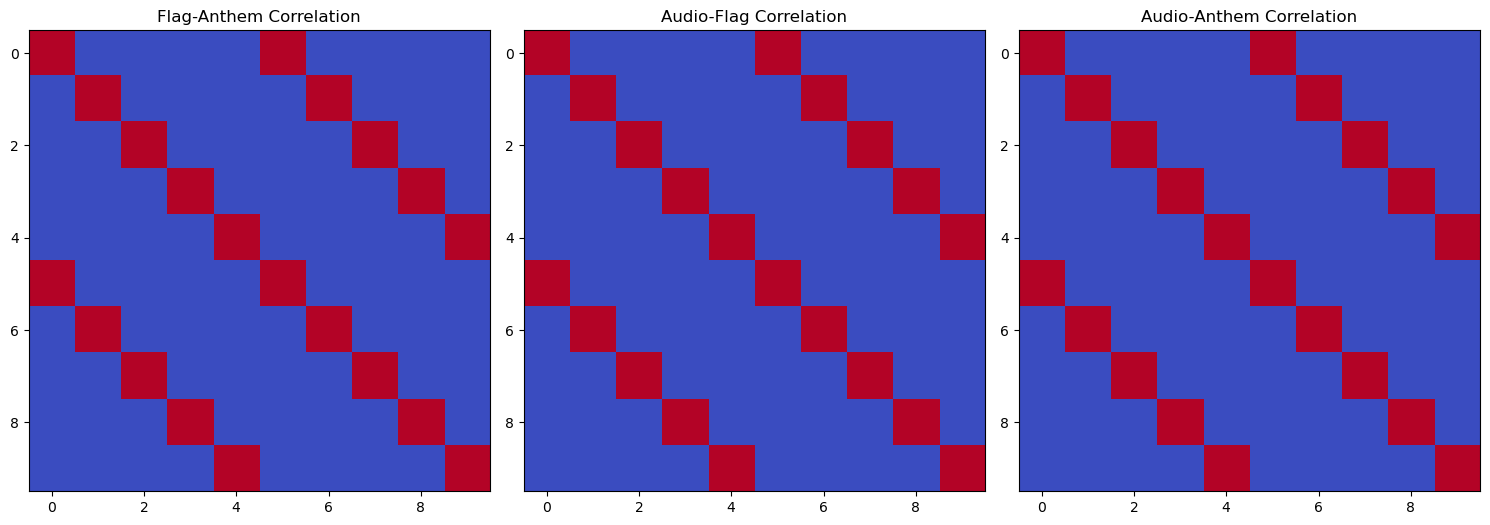

In [17]:
corr_fa = np.corrcoef(flag_cca.T, anthem_cca.T)
corr_af = np.corrcoef(audio_cca.T, flag_cca_af.T)
corr_aa = np.corrcoef(audio_cca_aa.T, anthem_cca_aa.T)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(corr_fa, cmap='coolwarm', interpolation='nearest')
plt.title('Flag-Anthem Correlation')

plt.subplot(1, 3, 2)
plt.imshow(corr_af, cmap='coolwarm', interpolation='nearest')
plt.title('Audio-Flag Correlation')

plt.subplot(1, 3, 3)
plt.imshow(corr_aa, cmap='coolwarm', interpolation='nearest')
plt.title('Audio-Anthem Correlation')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.decomposition import KernelPCA

In [19]:
min_samples = min(len(flag_features), len(anthem_features), len(audio_features))

flag_features = flag_features[:min_samples]
anthem_features = anthem_features[:min_samples]
audio_features = audio_features[:min_samples]

# Normalize features
scaler = StandardScaler()
flag_features = scaler.fit_transform(flag_features)
anthem_features = scaler.fit_transform(anthem_features)
audio_features = scaler.fit_transform(audio_features)

# Apply KernelPCA for Kernel CCA (Nonlinear Transformations)
kpca_flag = KernelPCA(n_components=10, kernel="rbf", gamma=0.1)
kpca_anthem = KernelPCA(n_components=10, kernel="rbf", gamma=0.1)
kpca_audio = KernelPCA(n_components=10, kernel="rbf", gamma=0.1)

flag_kpca = kpca_flag.fit_transform(flag_features)
anthem_kpca = kpca_anthem.fit_transform(anthem_features)
audio_kpca = kpca_audio.fit_transform(audio_features)

# Apply Linear CCA after KernelPCA
cca = CCA(n_components=5)
flag_cca, anthem_cca = cca.fit_transform(flag_kpca, anthem_kpca)

cca_af = CCA(n_components=5)
audio_cca, flag_cca_af = cca_af.fit_transform(audio_kpca, flag_kpca)

cca_aa = CCA(n_components=5)
audio_cca_aa, anthem_cca_aa = cca_aa.fit_transform(audio_kpca, anthem_kpca)

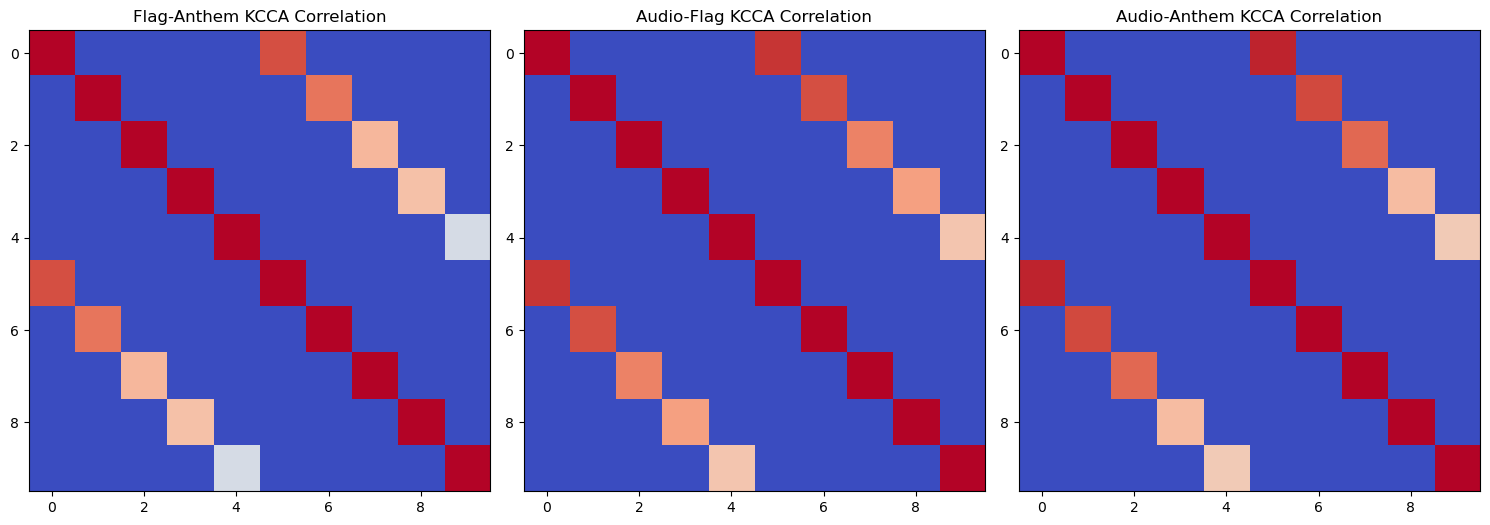

In [20]:
corr_fa_k = np.corrcoef(flag_cca.T, anthem_cca.T)
corr_af_k = np.corrcoef(audio_cca.T, flag_cca_af.T)
corr_aa_k = np.corrcoef(audio_cca_aa.T, anthem_cca_aa.T)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(corr_fa_k, cmap='coolwarm', interpolation='nearest')
plt.title('Flag-Anthem KCCA Correlation')

plt.subplot(1, 3, 2)
plt.imshow(corr_af_k, cmap='coolwarm', interpolation='nearest')
plt.title('Audio-Flag KCCA Correlation')

plt.subplot(1, 3, 3)
plt.imshow(corr_aa_k, cmap='coolwarm', interpolation='nearest')
plt.title('Audio-Anthem KCCA Correlation')

plt.tight_layout()
plt.show()